# ·基于配体的筛选：化合物相似性

- 分子相似性

 - 分子描述符

 - 分子指纹图

- 基于子结构的指纹

 - MACCS 指纹

- Morgan 指纹和圆形指纹

- 分子相似性度量

 - Tanimoto系数

 - Dice系数

 - 虚拟筛查

- 利用相似性搜索进行虚拟筛选

 - 富集图

### *实际*内容

- 导入和绘制分子
- 计算分子描述符
  - 1D 分子描述符：分子量
  - 2D 分子描述符：MACCS 指纹图
  - 2D 分子描述符：Morgan 指纹图
- 计算分子相似性
  - MACCS 指纹：Tanimoto 和 Dice 的相似性
  - Morgan 指纹：Tanimoto 和 Dice 的相似性
- 使用相似性搜索进行虚拟筛选
  - 将查询分子与数据集中的所有分子进行比较
  - 相似度值的分布
  - 可视化大多数相似分子
  - 生成富集图
  - 计算富集因子

### 分子相似性
分子相似性是化学信息学中一个众所周知且经常使用的概念。比较分子及其特性可以以多种不同的方式使用，并帮助我们识别具有所需特性和生物活性的新分子。

相似性质原理 （SPP） 以及构效关系 （SAR） 方法基于结构相似的分子具有相似的性质，因此具有相似的生物活性的假设。在这种情况下，虚拟筛选遵循这个想法，在给定的一组具有已知结合亲和力的分子中搜索相似的分子，并将这些分子作为潜在的新活性分子提出。

### 分子描述符[¶]
根据应用的不同，可以通过多种不同的方式评估相似性

- 1D 分子描述符：溶解度、logP、分子量、熔点。
  - 全局描述符：只有一个值代表整个分子
  - 通常不包含足够的信息来应用于机器学习 （ML）
  - 可以添加到 2D 指纹图谱中，以改进 ML 的分子编码
- 2D 分子描述符：分子图、路径、片段、原子环境
  - Detailed representation of individual parts of the molecule
  - 每个分子包含许多特征/位，称为指纹
  - 常用于相似性搜索和 ML
- 3D 分子描述符：形状、立体化学
  - 由于分子的柔韧性，不如 2D 表示稳健（分子的“正确”构象是什么？生物相似性
  - 生物指纹图谱，例如单个比特代表针对不同靶标的生物活性测量
  - 不受分子结构的影响
  - 需要实验（或预测）数据

### 分子指纹[¶]

#### 基于子结构的指纹[¶]
分子指纹图谱是分子的计算表示，它以位串、位向量或数组的形式编码化学和分子特征。每个位对应于一个预定义的分子特征或环境，其中“1”表示存在，“0”表示不存在特征。请注意，某些实现是基于计数的。因此，它们计算特定特征出现的频率。

有多种方法可以设计指纹。在这里，我们介绍 MACCS 密钥和 Morgan 指纹作为两种常用的 2D 指纹。从关于 [fingerprints](https://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-fingerprints) 的 `rdkit` 文档中可以看出，`rdkit` 还提供了多个备用指纹。

#### MACCS 指纹[¶]
分子 ACCess 系统 （MACCS） 指纹图谱，也称为 MACCS 结构键，由 166 个预定义的结构片段组成。每个位置查询是否存在一个特定的结构片段或键。各个键由药物化学家凭经验定义，易于使用和解释

#### Morgan 指纹和圆形指纹[¶]

这一系列指纹基于 Morgan 算法。这些位对应于分子中每个原子的圆形环境。要考虑的相邻键和原子的数量由半径设置。也可以定义位串的长度，更长的位串将被修改为所需的长度。因此，Morgan 指纹不限于一定数量的位。有关 [Morgan 指纹]更多信息，请参阅 `rdkit` 文档。扩展连接指纹 （ECFP） 也是使用 Morgan 算法的变体派生的常用指纹，请参阅 [J. Chem. Inf. 模型。（2010），50,742-754](https://pubs.acs.org/doi/abs/10.1021/ci100050t) 了解更多信息。

### 分子相似性度量[¶]
一旦计算出描述符/指纹图谱，就可以对它们进行比较以评估两个分子之间的相似性。分子相似性可以用许多不同的相似性系数来量化，两种常见的相似性衡量标准是谷本指数和骰子指数

In [1]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import (
    PandasTools,
    Draw,
    Descriptors,
    MACCSkeys,
    rdFingerprintGenerator,
)

In [2]:
from pathlib import Path
import os

# 获取当前工作目录
HERE = Path(os.getcwd())
DATA = HERE / 'data'
if not DATA.exists():
    DATA.mkdir(parents=True, exist_ok=True)
print(DATA)


/Users/wangyang/Desktop/Breast_cancer_brain_metastasis/wang_Gene/AIDD/04_Ligand-based_screening_compound_similarity/data


# 让我们定义一些分子示例。  

首先，我们将使用 `rdkit` 库中的 `MolFromSmiles` 函数将 SMILES 字符串转换为 `rdkit` 格式的分子对象。


# 定义一些分子


In [3]:
# Molecules in SMILES format
molecule_smiles = [
    "CC1C2C(C3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4O)O)O)O)C(=O)N)N(C)C)O",
    "CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=C(C=C3)O)N)C(=O)O)C",
    "C1=COC(=C1)CNC2=CC(=C(C=C2C(=O)O)S(=O)(=O)N)Cl",
    "CCCCCCCCCCCC(=O)OCCOC(=O)CCCCCCCCCCC",
    "C1NC2=CC(=C(C=C2S(=O)(=O)N1)S(=O)(=O)N)Cl",
    "CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC(=O)O)C)C",
    "CC1(C2CC3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4O)O)O)O)C(=O)N)N(C)C)O",
    "CC1C(CC(=O)C2=C1C=CC=C2O)C(=O)O",
]

# List of molecule names
molecule_names = [
    "Doxycycline",
    "Amoxicilline",
    "Furosemide",
    "Glycol dilaurate",
    "Hydrochlorothiazide",
    "Isotretinoin",
    "Tetracycline",
    "Hemi-cycline D",
]

## 为这些分子生成 DataFrame 并添加它们的 ROMol 对象。

,smiles,name,ROMol
0,CC1C2C(C3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4...,Doxycycline,
1,CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=C(C=C3)O)N)C...,Amoxicilline,

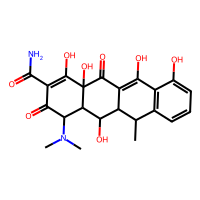
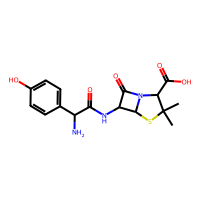

In [4]:
molecules = pd.DataFrame({"smiles": molecule_smiles, "name": molecule_names})
PandasTools.AddMoleculeColumnToFrame(molecules, smilesCol="smiles")
PandasTools.RenderImagesInAllDataFrames(True)
# Show first 2 molecules
molecules.head(2)

##  可视化所有分子。

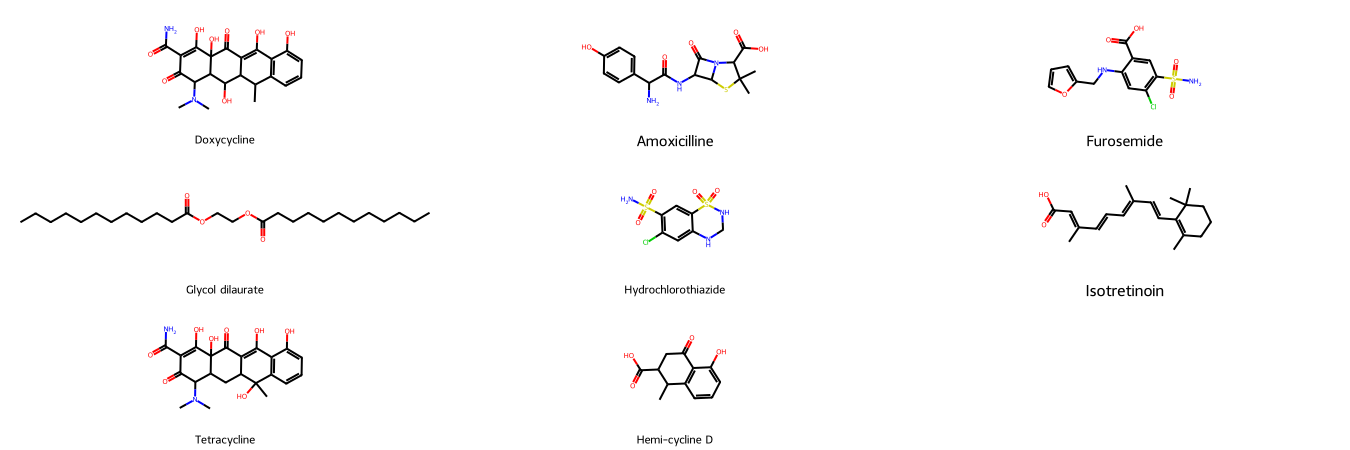

In [5]:
Draw.MolsToGridImage(
    molecules["ROMol"].to_list(),
    molsPerRow=3,
    subImgSize=(450, 150),
    legends=molecules["name"].to_list(),
)

## 计算分子描述符

我们提取并生成 1D 和 2D 分子描述符来比较我们的分子。对于 2D 描述符，会生成不同类型的指纹图谱，以便稍后用于计算分子相似性。

一维分子描述符：分子量¶
我们计算示例结构的分子量

In [6]:
# 注释- -用MolWt函数计算分子量应用函数来应用Mol Wt函数
# 到DataFrame中的所有ROMol对象
molecules["molecule_weight"] = molecules.ROMol.apply(Descriptors.MolWt)
# 按分子量对分子进行排序
molecules.sort_values(["molecule_weight"], ascending=False, inplace=True)

我们用相似的分子量绘制分子结构以进行视觉比较：分子量是分子相似性的可行描述符吗？

In [7]:
# S只显示分子名称和分子量
molecules[["smiles", "name", "molecule_weight"]]

,smiles,name,molecule_weight
0,CC1C2C(C3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4...,Doxycycline,444.440
6,CC1(C2CC3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4...,Tetracycline,444.440
3,CCCCCCCCCCCC(=O)OCCOC(=O)CCCCCCCCCCC,Glycol dilaurate,426.682
1,CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=C(C=C3)O)N)C...,Amoxicilline,365.411
2,C1=COC(=C1)CNC2=CC(=C(C=C2C(=O)O)S(=O)(=O)N)Cl,Furosemide,330.749
5,CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC(=O)O)C)C,Isotretinoin,300.442
4,C1NC2=CC(=C(C=C2S(=O)(=O)N1)S(=O)(=O)N)Cl,Hydrochlorothiazide,297.745
7,CC1C(CC(=O)C2=C1C=CC=C2O)C(=O)O,Hemi-cycline D,220.224


## 我们用它们的分子量画出分子。

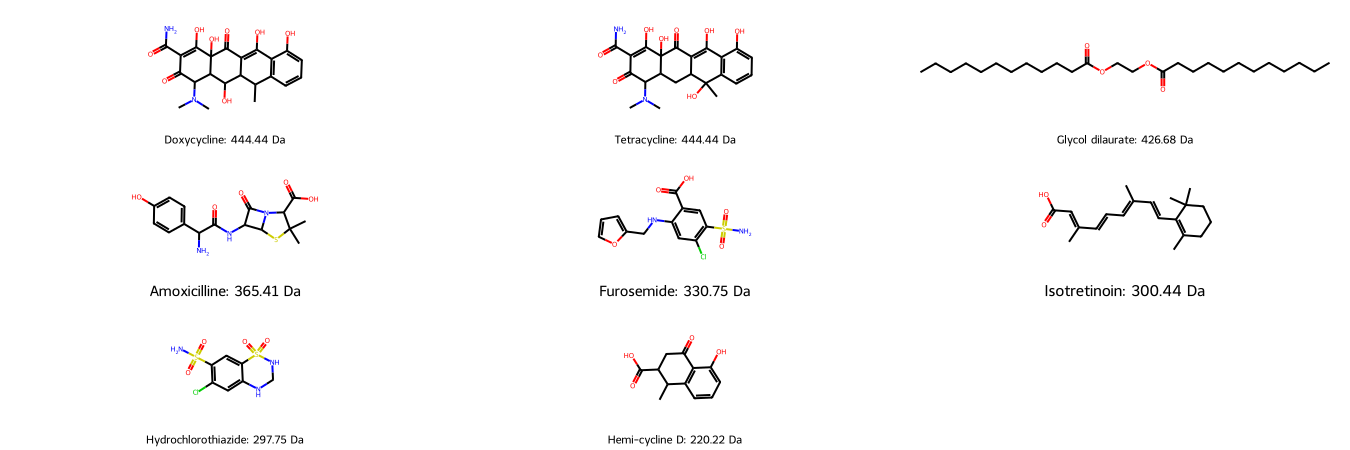

In [8]:
Draw.MolsToGridImage(
    molecules["ROMol"],
    legends=[
        f"{molecule['name']}: {molecule['molecule_weight']:.2f} Da"
        for index, molecule in molecules.iterrows()
    ],
    subImgSize=(450, 150),
    molsPerRow=3,
)

正如我们所看到的，具有相似分子量的分子可以具有相似的结构（例如多西环素/四环素），但它们也可以具有相似数量的原子，但排列完全不同（例如多西环素/二月桂酸乙二醇酯或氢氯噻嗪/异维A酸）。

为了解释分子的更详细特性，我们现在看一下二维分子描述符。

## 2D 分子描述符：MACCS 指纹¶

示例分子：让我们使用 DataFrame 中的示例分子。

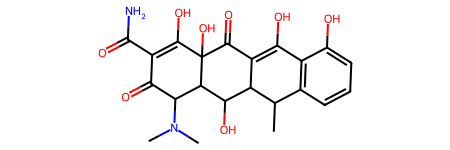

In [9]:
molecule = molecules["ROMol"][0]
molecule

注解：我们可以使用 `rdkit` 库中的 `GetMACCSKeysFingerprint` 函数来计算 MACCS 指纹。
MACCS 指纹可以使用 rdkit 轻松生成。

In [10]:
maccs_fp = MACCSkeys.GenMACCSKeys(molecule)

由于显式位向量不是人类可读的，因此我们将进一步将它们转换为位串。

In [11]:

maccs_fp.ToBitString()

'00000000000000000000000000100000000000000000000000100110000000000010000010101000000011100100110101010100010000101100010000100001000101001001111111101111101011111111110'

应用于所有分子：将所有分子的 MACCS 指纹添加到 DataFrame 中。

In [12]:
molecules["maccs"] = molecules.ROMol.apply(MACCSkeys.GenMACCSKeys)

## 2D 分子描述符：Morgan 指纹¶
我们还可以用 rdkit 计算圆形 Morgan 指纹。Morgan 指纹可以计算为 int 或 bit vector。我们指定半径 2 和长度为 2048 的向量。

示例分子：让我们再次使用我们的示例分子。

将 Morgan 指纹生成为 int 向量。



In [13]:
fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
circular_int_fp = fpg.GetCountFingerprint(molecule)
circular_int_fp

In [14]:

print(f"Print non-zero elements:\n{circular_int_fp.GetNonzeroElements()}")

Print non-zero elements:
{45: 1, 118: 1, 140: 1, 163: 1, 276: 1, 303: 1, 309: 1, 314: 2, 371: 1, 438: 1, 525: 1, 557: 1, 650: 3, 673: 1, 699: 1, 807: 6, 824: 1, 829: 1, 881: 1, 1009: 1, 1019: 5, 1027: 1, 1039: 1, 1057: 3, 1060: 1, 1061: 1, 1070: 1, 1082: 1, 1088: 1, 1119: 1, 1154: 1, 1163: 2, 1171: 1, 1257: 1, 1296: 1, 1309: 1, 1341: 1, 1380: 9, 1389: 1, 1457: 1, 1471: 1, 1487: 1, 1582: 1, 1602: 3, 1607: 1, 1630: 1, 1747: 1, 1750: 2, 1831: 1, 1833: 1, 1857: 1, 1873: 3, 1917: 1, 1932: 1, 2000: 1, 2029: 1}


## 生成 Morgan 指纹作为位向量。

In [15]:
# 请注意，该函数将列表作为输入参数
# （即使我们只想传递一个分子）
circular_bit_fp = fpg.GetFingerprint(molecule)
circular_bit_fp

In [16]:

print(f"Print top 400 fingerprint bits:\n{circular_bit_fp.ToBitString()[:400]}")

Print top 400 fingerprint bits:
0000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000010000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000001000001000010000000000000000000000000000000000000000000000000000000010000000000000000000000000000


应用于所有分子：将所有分子的 Morgan 指纹（作为位向量）添加到 DataFrame 中。

In [17]:
molecules["morgan"] = molecules["ROMol"].map(fpg.GetFingerprint)

## 计算分子相似性¶
在下文中，我们将对两种指纹类型（即 MACCS 和 Morgan 指纹）应用两个相似性度量，即 Tanimoto 和 Dice。

分子对示例：将两个 MACCS 指纹图谱与 Tanimoto 相似性进行比较。

In [18]:
# Example molecules
molecule1 = molecules["ROMol"][0]
molecule2 = molecules["ROMol"][1]

# Example fingerprints
maccs_fp1 = MACCSkeys.GenMACCSKeys(molecule1)
maccs_fp2 = MACCSkeys.GenMACCSKeys(molecule2)

## 计算两个不同分子之间的 Tanimoto 系数。

In [19]:

DataStructs.TanimotoSimilarity(maccs_fp1, maccs_fp2)

0.5909090909090909

## 计算同一分子之间的 Tanimoto 系数。

In [20]:

DataStructs.TanimotoSimilarity(maccs_fp1, maccs_fp1)

1.0

在下文中，我们想将 query molecule 与我们的 molecule 列表进行比较。因此，我们使用 rdkit 中的 BulkTanimotoSimilarity 和 BulkDiceSimilarity，它们根据相似性度量计算查询指纹与指纹列表的相似性。我们将根据 Tanimoto/Dice 相似性测量调查 MACCS/Morgan 指纹图谱比较的所有组合。

## MACCS 指纹：Tanimoto 相似度和 Dice 相似度¶
将 MACCS 指纹之间的 Tanimoto 和 Dice 相似性添加到 DataFrame 中。

In [21]:
# 定义分子查询和列表
molecule_query = molecules["maccs"][0]
molecule_list = molecules["maccs"].to_list()
# 计算查询元素和列表元素之间的相似度值
molecules["tanimoto_maccs"] = DataStructs.BulkTanimotoSimilarity(molecule_query, molecule_list)
molecules["dice_maccs"] = DataStructs.BulkDiceSimilarity(molecule_query, molecule_list)

按 MACCS 指纹的 Tanimoto 相似性对 DataFrame 进行排序（仅显示 name 和 similarity 列！

In [22]:
preview = molecules.sort_values(["tanimoto_maccs"], ascending=False).reset_index()
preview[["name", "tanimoto_maccs", "dice_maccs"]]

,name,tanimoto_maccs,dice_maccs
0,Doxycycline,1.000000,1.000000
1,Tetracycline,0.928571,0.962963
2,Amoxicilline,0.590909,0.742857
3,Hemi-cycline D,0.403509,0.575000
4,Furosemide,0.321839,0.486957
5,Hydrochlorothiazide,0.306818,0.469565
6,Isotretinoin,0.288136,0.447368
7,Glycol dilaurate,0.149254,0.259740


注意：根据定义，Tanimoto 和 Dice 相似性测量会导致相同的分子排名，但 Dice 相似度的值更高（请参阅自己去找： Tanimoto 和 Dice 方程，我这边不自己找了）。

## 绘制按 MACCS 指纹的 Tanimoto 相似性排序的分子。



In [23]:
def draw_ranked_molecules(molecules, sort_by_column):
    """
    绘制按给定列排序的分子。

    Parameters
    ----------
    molecules : pandas.DataFrame
                分子(用' ROMol '和' name '列，并按列排序)。
    sort_by_column : str
        用于对分子进行排序的柱子名称。

    Returns
    -------
    Draw.MolsToGridImage
        2D visualization of sorted molecules.
    """

    molecules_sorted = molecules.sort_values([sort_by_column], ascending=False).reset_index()
    return Draw.MolsToGridImage(
        molecules_sorted["ROMol"],
        legends=[
            f"#{index+1} {molecule['name']}, similarity={molecule[sort_by_column]:.2f}"
            for index, molecule in molecules_sorted.iterrows()
        ],
        molsPerRow=3,
        subImgSize=(450, 150),
    )

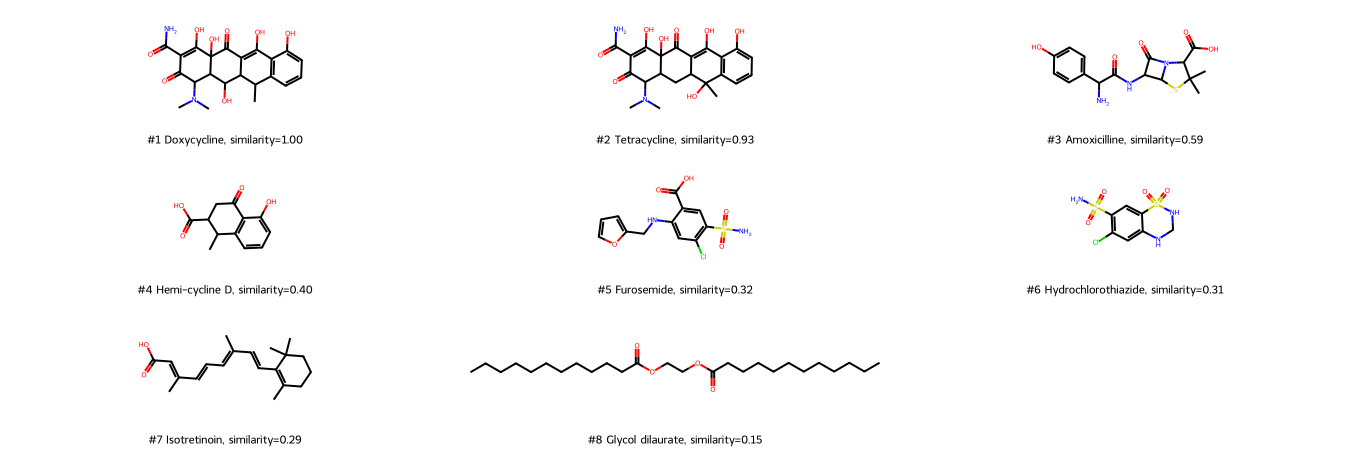

In [24]:
draw_ranked_molecules(molecules, "tanimoto_maccs")

在 MACCS 指纹图谱中，四环素是最相似的分子（高分），其次是阿莫西林。与 1D 描述符分子量相反，线性分子二月桂酸乙二醇被认为是不同的（最后一级）。



## Morgan 指纹：Tanimoto 相似度和 Dice 相似度¶
将 Morgan 指纹之间的 Tanimoto 和 Dice 相似性添加到 DataFrame 中。

In [25]:
# 定义分子查询和列表
molecule_query = molecules["morgan"][0]
molecule_list = molecules["morgan"].to_list()
# 计算查询元素和列表元素之间的相似度值
molecules["tanimoto_morgan"] = DataStructs.BulkTanimotoSimilarity(molecule_query, molecule_list)
molecules["dice_morgan"] = DataStructs.BulkDiceSimilarity(molecule_query, molecule_list)

按 Morgan 指纹的 Tanimoto 相似性对 DataFrame 进行排序。

In [26]:
preview = molecules.sort_values(["tanimoto_morgan"], ascending=False).reset_index()
preview[["name", "tanimoto_morgan", "dice_morgan", "tanimoto_maccs", "dice_maccs"]]

,name,tanimoto_morgan,dice_morgan,tanimoto_maccs,dice_maccs
0,Doxycycline,1.000000,1.000000,1.000000,1.000000
1,Tetracycline,0.534247,0.696429,0.928571,0.962963
2,Hemi-cycline D,0.308824,0.471910,0.403509,0.575000
3,Amoxicilline,0.144444,0.252427,0.590909,0.742857
4,Furosemide,0.098901,0.180000,0.321839,0.486957
5,Isotretinoin,0.067416,0.126316,0.288136,0.447368
6,Hydrochlorothiazide,0.058824,0.111111,0.306818,0.469565
7,Glycol dilaurate,0.054795,0.103896,0.149254,0.259740


绘制按 Morgan 指纹的 Tanimoto 相似性排序的分子。



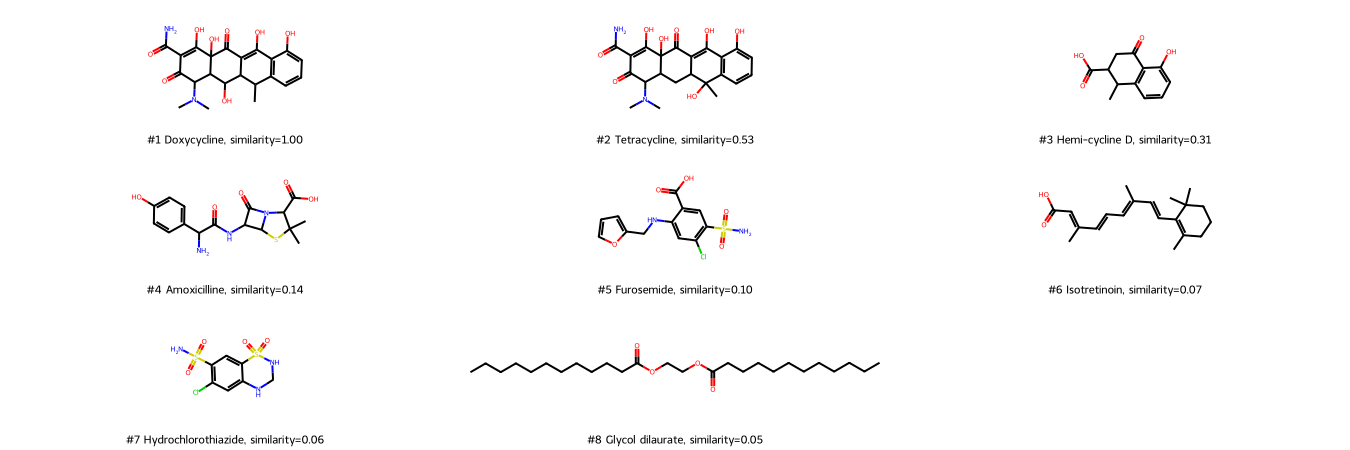

In [27]:
draw_ranked_molecules(molecules, "tanimoto_morgan")

我们根据 MACCS 和 Morgan 指纹比较了 Tanimoto 的相似性。因此，我们根据 Morgen 指纹绘制了 Tanimoto 相似性与基于 MACCS 指纹的 Tanimoto 相似性。

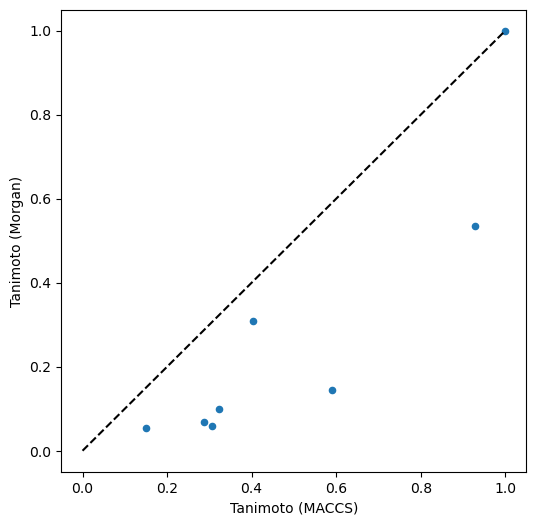

In [28]:
fig, ax = plt.subplots(figsize=(6, 6))
molecules.plot("tanimoto_maccs", "tanimoto_morgan", kind="scatter", ax=ax)
ax.plot([0, 1], [0, 1], "k--")
ax.set_xlabel("Tanimoto (MACCS)")
ax.set_ylabel("Tanimoto (Morgan)")
fig;

使用不同的指纹图谱（此处：MACCS 和 Morgan 指纹图谱）会导致不同的相似度值（此处：Tanimoto 相似性），因此也可能出现不同的分子相似性排名，如图所示。

Morgan 指纹图谱还认为四环素是与多西环素最相似的分子（但得分较低），而二月桂酸酯 Clycol dilaurate 是最不同的。然而，排名第二的是半细胞周期素 D，它是细胞周期蛋白的结构部分 - 可能是因为 Morgan 指纹图谱基于原子环境的算法（而 MACCS 指纹图谱则要求某些特性的出现）。

# 下面就是我们实战的部分了：❤️实战部分--------------请您开始实战了

## 1.数据集：从包含 SMILES 格式分子的 csv 文件中导入数据。

In [29]:
molecule_dataset = pd.read_csv(
    HERE / "../03_Molecular_filtration_of_unwanted_substructures/data/data_ubstructures_matches.csv",
    usecols=["molecule_chembl_id", "smiles", "pIC50"],
)
print(f"Number of molecules in dataset: {len(molecule_dataset)}")
molecule_dataset.head(5)

Number of molecules in dataset: 1738


,molecule_chembl_id,smiles,pIC50
0,CHEMBL3685304,C[C@@H](Nc1ncnc2c(C(N)=O)cccc12)c1cccc(NC(=O)c...,11.000000
1,CHEMBL4443279,Fc1ccccc1Oc1nc(Nc2ccc(-c3nnn[nH]3)cc2)ncc1Cl,10.920819
2,CHEMBL4462759,COc1ccc(Oc2nc(Nc3ccc(-c4nnn[nH]4)cc3)ncc2Cl)cc1,10.920819
3,CHEMBL4476212,Fc1ccc(Oc2nc(Nc3ccc(-c4nnn[nH]4)cc3)ncc2Cl)cc1,10.920819
4,CHEMBL3675462,C[C@@H](Nc1ncnc2c(C(N)=O)cccc12)c1cccc(NC(=O)c...,10.522879


## 2.Query：
靶向疗法
曲妥珠单抗（Trastuzumab）

说明: 曲妥珠单抗是一种单克隆抗体，无法用简单的SMILES表示。
拉帕替尼（Lapatinib）

SMILES: CC1=CC(=CC=C1NC2=NC=C(C=N2)C3=CC(=C(C=C3)Cl)OC4=CC=CC=N4)C(F)(F)F
帕博西尼（Palbociclib）

SMILES: CC1=C(C=CC=N1)N2CCN(CC2)C3=NC(=NC=C3)N

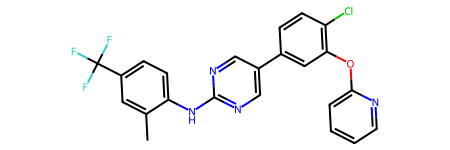

In [139]:
query = Chem.MolFromSmiles("CC1=CC(=CC=C1NC2=NC=C(C=N2)C3=CC(=C(C=C3)Cl)OC4=CC=CC=N4)C(F)(F)F")
query

## 3. 为查询分子生成 MACCS 和 Morgan 指纹。



In [140]:
maccs_fp_query = MACCSkeys.GenMACCSKeys(query)
circular_fp_query = fpg.GetCountFingerprint(query)

## 4. 为我们数据集中的所有分子生成 MACCS 和 Morgan 指纹图谱。



In [141]:
PandasTools.AddMoleculeColumnToFrame(molecule_dataset, "smiles")
circular_fp_list = molecule_dataset["ROMol"].apply(fpg.GetCountFingerprint).tolist()
maccs_fp_list = molecule_dataset["ROMol"].apply(MACCSkeys.GenMACCSKeys).tolist()

## 5. 计算查询分子 （Gefitinib） 和我们数据集中的所有分子（使用 MACCS 和 Morgan 指纹）之间的 Tanimoto 相似性。

In [142]:
molecule_dataset["tanimoto_maccs"] = DataStructs.BulkTanimotoSimilarity(
    maccs_fp_query, maccs_fp_list
)
molecule_dataset["tanimoto_morgan"] = DataStructs.BulkTanimotoSimilarity(
    circular_fp_query, circular_fp_list
)

## 5. 计算查询分子 （Gefitinib） 和文件中的所有分子 （MACCS， Morgan） 的 Dice 相似性。

In [143]:
molecule_dataset["dice_maccs"] = DataStructs.BulkDiceSimilarity(maccs_fp_query, maccs_fp_list)
molecule_dataset["dice_morgan"] = DataStructs.BulkDiceSimilarity(
    circular_fp_query, circular_fp_list
)

In [144]:

molecule_dataset[
    ["smiles", "tanimoto_maccs", "tanimoto_morgan", "dice_maccs", "dice_morgan"]
].head(5)

,smiles,tanimoto_maccs,tanimoto_morgan,dice_maccs,dice_morgan
1614,c1nc(N2CCC3(CCCCN3)CC2)c2nc[nH]c2n1,0.318182,0.094203,0.482759,0.172185
1270,NC(=O)c1cccc2c(N[C@H](CN3CCCC3)c3ccccc3)ncnc12,0.343284,0.188811,0.511111,0.317647
1537,NC(=O)c1cccc2c(N[C@H]3CCCNC3)ncnc12,0.365079,0.128788,0.534884,0.228188
1595,NC(=O)c1cccc2c(NC3CCCNC3)ncnc12,0.365079,0.128788,0.534884,0.228188
857,O=C(Cc1cccs1)Nc1cc2c(/C=C/c3ccccc3)n[nH]c2cc1N...,0.333333,0.180645,0.500000,0.306011


,molecule_chembl_id,smiles,pIC50,ROMol,tanimoto_maccs,tanimoto_morgan,dice_maccs,dice_morgan
1614,CHEMBL2420909,c1nc(N2CCC3(CCCCN3)CC2)c2nc[nH]c2n1,5.107905,,0.318182,0.094203,0.482759,0.172185
1270,CHEMBL3680521,NC(=O)c1cccc2c(N[C@H](CN3CCCC3)c3ccccc3)ncnc12,6.161151,,0.343284,0.188811,0.511111,0.317647
1537,CHEMBL3670407,NC(=O)c1cccc2c(N[C@H]3CCCNC3)ncnc12,5.366532,,0.365079,0.128788,0.534884,0.228188

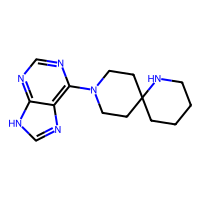
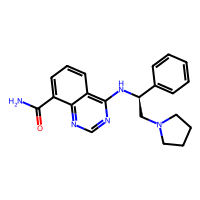
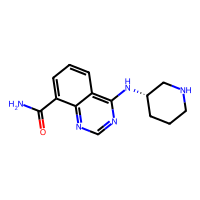

In [145]:
# Show all columns
molecule_dataset.head(3)

## 6. 相似度值的分布¶
如理论部分所述，对于相同的指纹（例如 MACCS 指纹），Tanimoto 相似度值低于 Dice 相似度值。此外，比较两种不同的指纹图谱（例如 MACCS 和 Morgan 指纹图谱），相似性度量值（例如 Tanimotot 相似度）会有所不同。

我们可以通过绘制直方图来查看分布。

首先，我们可以绘制 MACCS 指纹的 Tanimoto 相似性的分布。

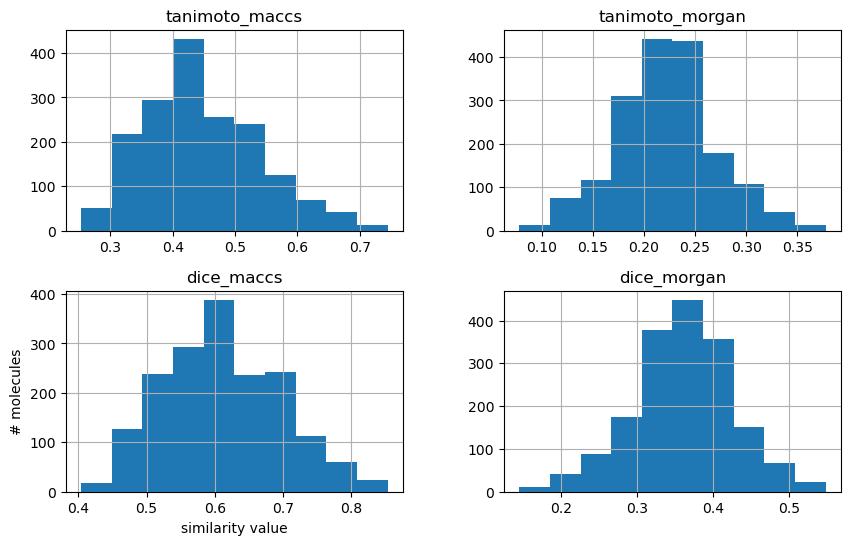

In [146]:
fig, axes = plt.subplots(figsize=(10, 6), nrows=2, ncols=2)
molecule_dataset.hist(["tanimoto_maccs"], ax=axes[0, 0])
molecule_dataset.hist(["tanimoto_morgan"], ax=axes[0, 1])
molecule_dataset.hist(["dice_maccs"], ax=axes[1, 0])
molecule_dataset.hist(["dice_morgan"], ax=axes[1, 1])
axes[1, 0].set_xlabel("similarity value")
axes[1, 0].set_ylabel("# molecules")
fig;

其次，我们可以在这里比较相似之处。这一次，我们直接比较一下 Tanimoto 和 Dice 这两个指纹的相似性。



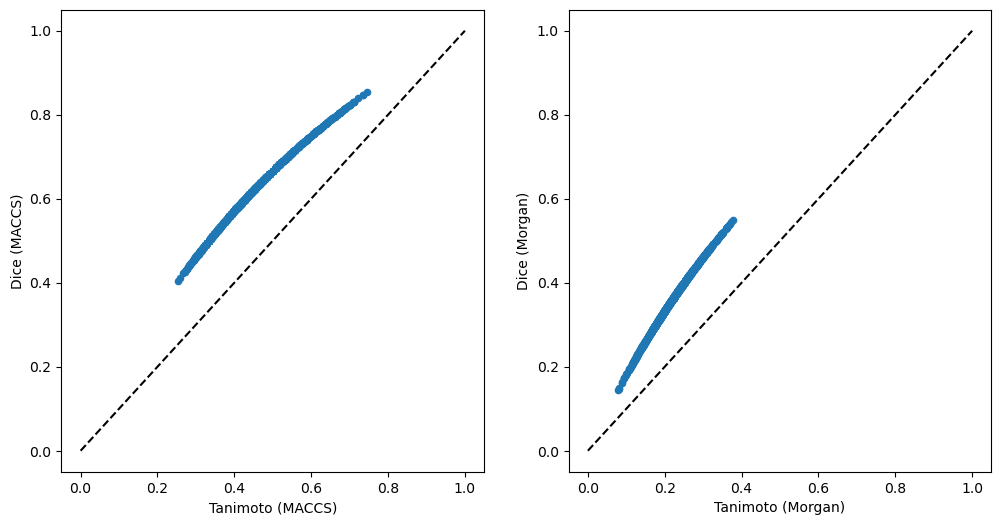

In [147]:
fig, axes = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)

molecule_dataset.plot("tanimoto_maccs", "dice_maccs", kind="scatter", ax=axes[0])
axes[0].plot([0, 1], [0, 1], "k--")
axes[0].set_xlabel("Tanimoto (MACCS)")
axes[0].set_ylabel("Dice (MACCS)")

molecule_dataset.plot("tanimoto_morgan", "dice_morgan", kind="scatter", ax=axes[1])
axes[1].plot([0, 1], [0, 1], "k--")
axes[1].set_xlabel("Tanimoto (Morgan)")
axes[1].set_ylabel("Dice (Morgan)")

fig;

相似性分布对于解释相似性值很重要，例如，对于 MACCS 或 Morgan 指纹图谱，以及 Tanimoto 或 Dice 相似性，需要对值 0.6 进行不同的评估。

可视化最相似的分子¶
我们目视检查吉非替尼的结构与我们排名中最相似的分子相比，包括有关其生物活性的信息（pIC50 源自 01 中的 ChEMBL 数据库）。

在这里，我们根据 Morgan 指纹按 Tanimoto 相似性对 DataFrame 进行排序。

,molecule_chembl_id,smiles,pIC50,ROMol,tanimoto_maccs,tanimoto_morgan,dice_maccs,dice_morgan
307,CHEMBL3680595,C[C@@H](Nc1ncnc2c(C(N)=O)cccc12)c1cccc(Nc2ncc(...,8.638272,,0.687500,0.377778,0.814815,0.548387
97,CHEMBL3680533,CC(Nc1ncnc2c(C(N)=O)cccc12)c1cccc(Nc2cc(C(F)(F...,9.508638,,0.604167,0.373134,0.753247,0.543478
1700,CHEMBL3954884,O=C(O)c1ccccc1Nc1nccc(Nc2cccc(C(F)(F)F)c2)n1,4.590067,,0.591837,0.368852,0.743590,0.538922

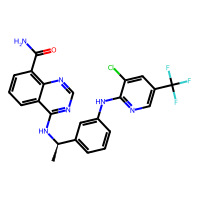
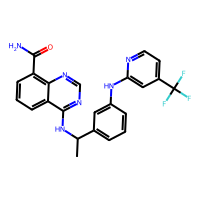
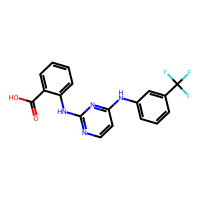

In [148]:
molecule_dataset.sort_values(["tanimoto_morgan"], ascending=False).head(3)

## 7.显示查询及其最相似的分子以及分子的生物活性。

In [149]:
top_n_molecules = 100
top_molecules = molecule_dataset.sort_values(["tanimoto_morgan"], ascending=False).reset_index()
top_molecules = top_molecules[:top_n_molecules]
legends = [
    f"#{index+1} {molecule['molecule_chembl_id']}, pIC50={molecule['pIC50']:.2f}"
    for index, molecule in top_molecules.iterrows()
]
# 需要从legends 得到的分子的索引PIC50中排序，越来越高的分子排名靠前
top_molecules = top_molecules.sort_values(["pIC50"], ascending=False)

/opt/anaconda3/envs/teachopencadd/lib/python3.8/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


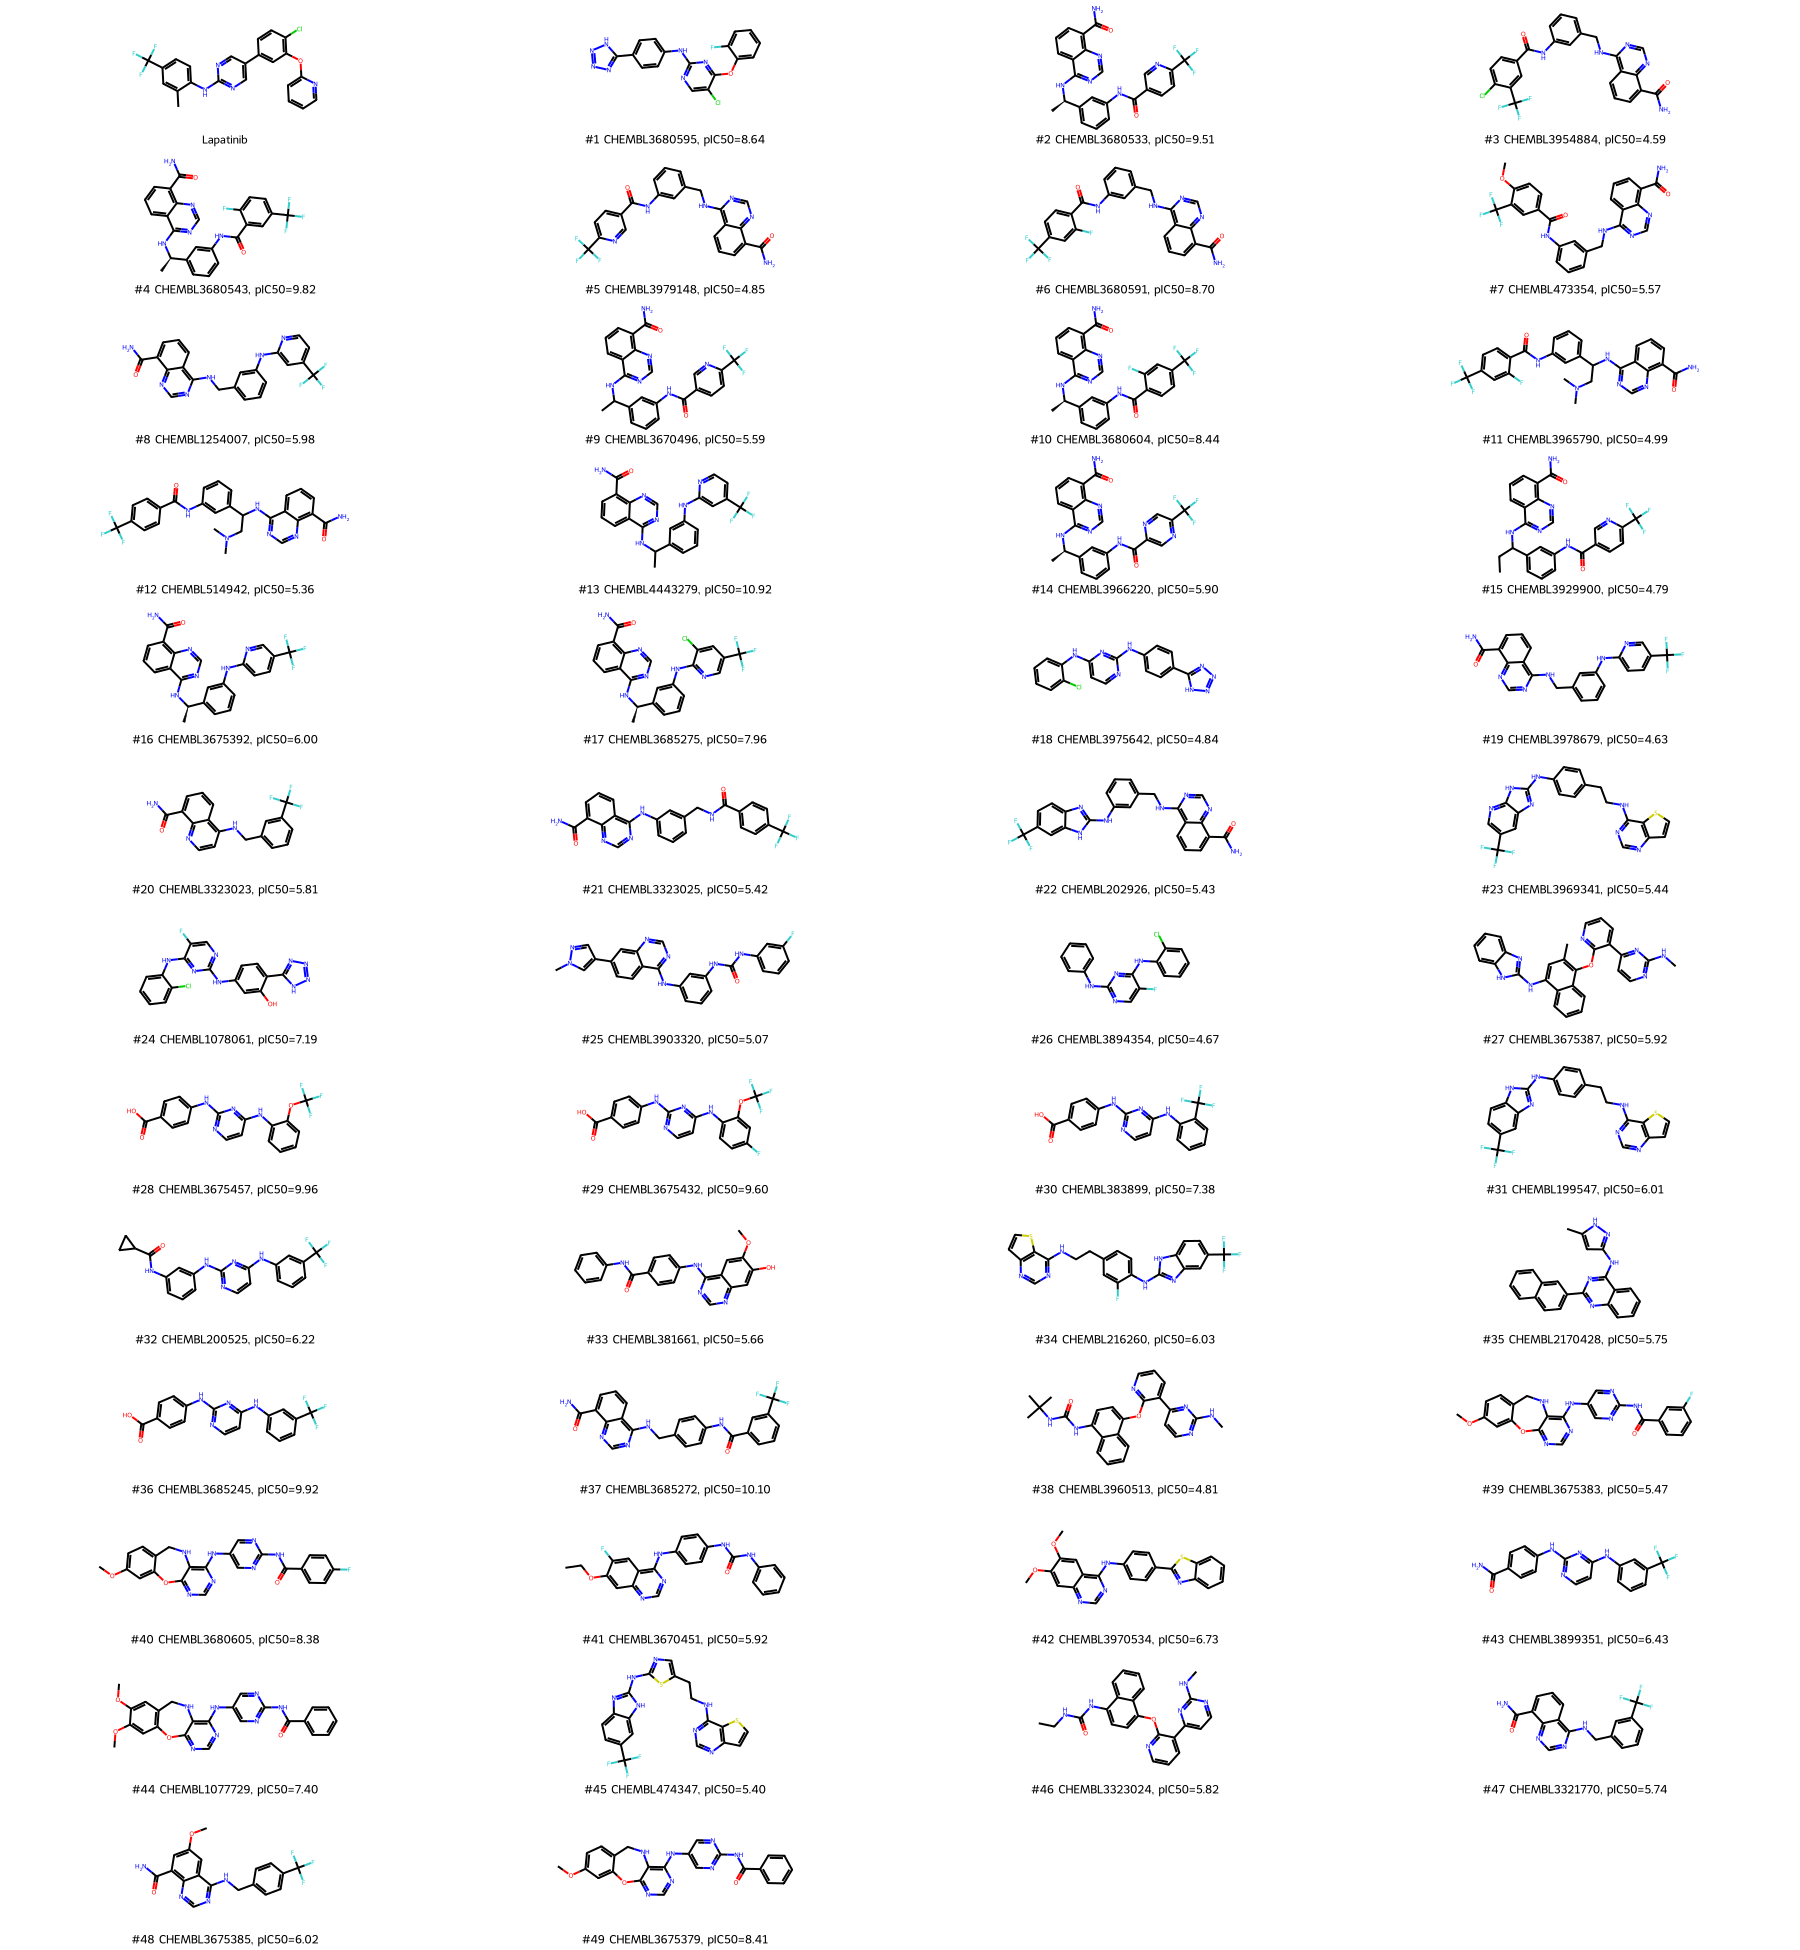

In [150]:
Chem.Draw.MolsToGridImage(
    mols=[query] + top_molecules["ROMol"].tolist(),
    legends=(["Lapatinib"] + legends),
    molsPerRow=4,
    subImgSize=(450, 150),
)

In [151]:
# 然后保存相识度值，需要保存的列名为：smiles, tanimoto_maccs, tanimoto_morgan, dice_maccs, dice_morgan, pIC50

# 需要将四个tanimoto_maccs, tanimoto_morgan, dice_maccs, dice_morgan越高的排序越靠前
top_molecules = top_molecules.sort_values(["tanimoto_morgan"], ascending=False)
top_maccs = top_molecules[["smiles", "tanimoto_maccs", "pIC50"]].rename(
    columns={"tanimoto_maccs": "MACCS similarity"}
)
top_morgan = top_molecules[["smiles", "tanimoto_morgan", "pIC50"]].rename(
    columns={"tanimoto_morgan": "Morgan similarity"}
)
top_similarity = pd.concat([top_maccs, top_morgan], axis=1)
top_similarity.to_csv(DATA / "top_similarity.csv", index=False)




在我们的数据集中，吉非替尼排名靠前的分子是吉非替尼条目（排名 1 和 2），其次是吉非替尼的改变，例如不同的苯代取代模式。注意：ChEMBL 包含吉非替尼（是一种经过充分研究的分子）的完整构效关系分析，因此在我们的数据集中有这么多吉非替尼样分子也就不足为奇了。

现在，我们根据我们的数据集检查相似性搜索区分活性和非活性分子的能力。因此，我们使用我们从 ChEMBL 收集的（抗 EGFR 的生物活性）的生物活性值

## 8.生成富集图¶
为了验证我们的虚拟筛选并查看检测到的活性分子的比例，我们生成了一个富集图。

富集图显示

整个数据集中排名靠前的分子（x 轴）的比率 与

来自整个数据集的活性分子（y 轴）的比率。

我们比较了 MACCS 和 Morgan 指纹的 Tanimoto 相似性。

为了决定我们将分子视为活性还是非活性，我们应用了常用的 pIC50 临界值 6.3。尽管文献中有多种建议，从 pIC50 临界值 5 到 7，甚至定义排除范围，但我们认为这个临界值是合理的。

,molecule_chembl_id,smiles,pIC50,ROMol,tanimoto_maccs,tanimoto_morgan,dice_maccs,dice_morgan
1614,CHEMBL2420909,c1nc(N2CCC3(CCCCN3)CC2)c2nc[nH]c2n1,5.107905,,0.318182,0.094203,0.482759,0.172185
1270,CHEMBL3680521,NC(=O)c1cccc2c(N[C@H](CN3CCCC3)c3ccccc3)ncnc12,6.161151,,0.343284,0.188811,0.511111,0.317647
1537,CHEMBL3670407,NC(=O)c1cccc2c(N[C@H]3CCCNC3)ncnc12,5.366532,,0.365079,0.128788,0.534884,0.228188

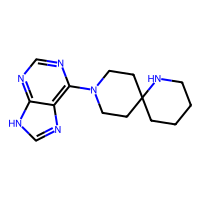
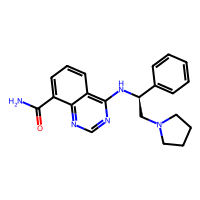
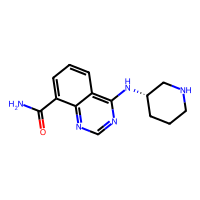

In [152]:
molecule_dataset.head(3)

In [153]:
def get_enrichment_data(molecules, similarity_measure, pic50_cutoff):
    """
    计算富集图的x和y值：
        x - % ranked dataset
        y - % true actives identified

    Parameters
    ----------
    molecules : pandas.DataFrame
        与查询分子具有相似值的分子。
    similarity_measure : str
        其中列名将用于对DataFrame进行排序。
    pic50_cutoff : float
        PIC50截断值用于区分活性分子和非活性分子。

    Returns
    -------
    pandas.DataFrame
        富集数据：通过相似性排序的数据集的百分比vs .确定的真实活动的百分比。
    """

    # 得到数据集中的分子数
    molecules_all = len(molecules)

    # 获得数据集中活性分子的数量
    actives_all = sum(molecules["pIC50"] >= pic50_cutoff)

    # 在通过我们的数据集进行迭代时，初始化一个列表，该列表将为活性分子和分子保留计数器
    actives_counter_list = []

    # Initialize counter for actives
    actives_counter = 0

    # Note: Data must be ranked for enrichment plots:
    # Sort molecules by selected similarity measure
    molecules.sort_values([similarity_measure], ascending=False, inplace=True)

    # Iterate over the ranked dataset and check each molecule if active (by checking bioactivity)
    for value in molecules["pIC50"]:
        if value >= pic50_cutoff:
            actives_counter += 1
        actives_counter_list.append(actives_counter)

    # Transform number of molecules into % ranked dataset
    molecules_percentage_list = [i / molecules_all for i in range(1, molecules_all + 1)]

    # Transform number of actives into % true actives identified
    actives_percentage_list = [i / actives_all for i in actives_counter_list]

    # Generate DataFrame with x and y values as well as label
    enrichment = pd.DataFrame(
        {
            "% ranked dataset": molecules_percentage_list,
            "% true actives identified": actives_percentage_list,
        }
    )

    return enrichment

## 9.设置用于区分活性和非活性分子的 pIC50 截止值...

In [154]:
pic50_cutoff = 6.3

## 10. 并获取 MACCS 和 Morgan 指纹图谱的丰富（使用 Tanimoto 相似性）。

In [155]:
similarity_measures = ["tanimoto_maccs", "tanimoto_morgan"]
enrichment_data = {
    similarity_measure: get_enrichment_data(molecule_dataset, similarity_measure, pic50_cutoff)
    for similarity_measure in similarity_measures
}

显示示例扩充数据。

In [156]:
# NBVAL_CHECK_OUTPUT
enrichment_data["tanimoto_maccs"].head()

,% ranked dataset,% true actives identified
0,0.000575,0.000841
1,0.001151,0.001682
2,0.001726,0.002523
3,0.002301,0.003364
4,0.002877,0.003364


## 11在最优和随机富集曲线旁边绘制富集数据！

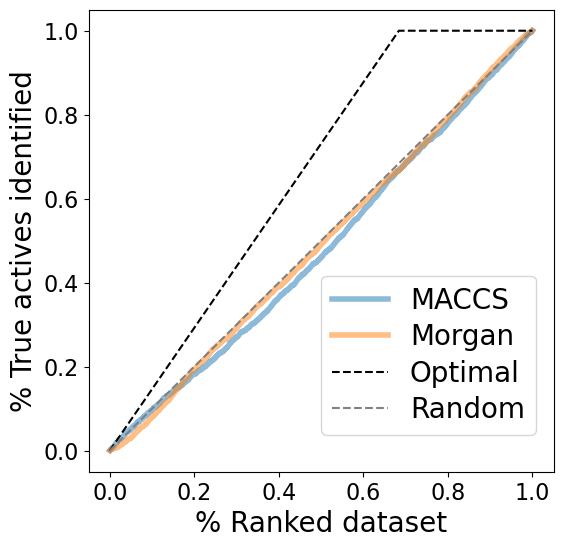

In [157]:
fig, ax = plt.subplots(figsize=(6, 6))

fontsize = 20

# Plot enrichment data
for similarity_measure, enrichment in enrichment_data.items():
    ax = enrichment.plot(
        ax=ax,
        x="% ranked dataset",
        y="% true actives identified",
        label=similarity_measure,
        alpha=0.5,
        linewidth=4,
    )
ax.set_ylabel("% True actives identified", size=fontsize)
ax.set_xlabel("% Ranked dataset", size=fontsize)

# Plot optimal curve: Ratio of actives in dataset
ratio_actives = sum(molecule_dataset["pIC50"] >= pic50_cutoff) / len(molecule_dataset)
ax.plot(
    [0, ratio_actives, 1],
    [0, 1, 1],
    label="Optimal curve",
    color="black",
    linestyle="--",
)

# Plot random curve
ax.plot([0, 1], [0, 1], label="Random curve", color="grey", linestyle="--")

plt.tick_params(labelsize=16)
plt.legend(
    labels=["MACCS", "Morgan", "Optimal", "Random"],
    loc=(0.5, 0.08),
    fontsize=fontsize,
    labelspacing=0.3,
)

# Save plot -- use bbox_inches to include text boxes
plt.savefig(
    DATA / "enrichment_plot.png",
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)

plt.show()

富集图显示，基于 Morgan 指纹的指纹比较性能略好于基于 MACCS 指纹的指纹比较。

## 12. 计算富集因子¶
（实验性）富集因子 （EF） 用于通过单个数字而不是绘图来访问方法的成功。这个想法是确定排名分子中前 x%（例如 5%）的活性分子的百分比，如下面的辅助函数所定义。

In [158]:
def calculate_enrichment_factor(enrichment, ranked_dataset_percentage_cutoff):
    """
    得到给定百分比的已排序数据集的实验富集因子。

    Parameters
    ----------
    enrichment : pd.DataFrame
        富集数据：按相似度和百分比排序的数据集的百分比识别出真正的活动者。
    ranked_dataset_percentage_cutoff : float or int
        富集因子计算中包含的已排序数据集的百分比。

    Returns
    -------
    float
        实验富集因子。
    """

    # Keep only molecules that meet the cutoff
    enrichment = enrichment[
        enrichment["% ranked dataset"] <= ranked_dataset_percentage_cutoff / 100
    ]
    # Get highest percentage of actives and the corresponding percentage of actives
    highest_enrichment = enrichment.iloc[-1]
    enrichment_factor = round(100 * float(highest_enrichment["% true actives identified"]), 1)
    return enrichment_factor

## 13. 此辅助函数计算排名前 x% 的分子中活性分子的随机富集（随机富集因子）。

In [159]:
def calculate_enrichment_factor_random(ranked_dataset_percentage_cutoff):
    """
    得到给定百分比的排序数据集的随机富集因子。

    Parameters
    ----------
    ranked_dataset_percentage_cutoff : float or int
        富集因子计算中包含的已排序数据集的百分比。

    Returns
    -------
    float
        Random enrichment factor.
    """

    enrichment_factor_random = round(float(ranked_dataset_percentage_cutoff), 1)
    return enrichment_factor_random

这个辅助函数计算排名前 x% 的分子中活性分子的最佳富集（最佳富集因子）。需要随机和最优富集因子来判断方法的实验富集因子有多好。

In [160]:
def calculate_enrichment_factor_optimal(molecules, ranked_dataset_percentage_cutoff, pic50_cutoff):
    """
    得到给定百分比的排序数据集的最优随机富集因子。

    Parameters
    ----------
    molecules : pandas.DataFrame
        包含所有分子和pIC50的数据框架。
    ranked_dataset_percentage_cutoff : float or int
        富集因子计算中包含的已排序数据集的百分比。
    activity_cutoff: float
        PIC50截断值用于区分活性分子和非活性分子

    Returns
    -------
    float
        Optimal enrichment factor.
    """

    ratio = sum(molecules["pIC50"] >= pic50_cutoff) / len(molecules) * 100
    if ranked_dataset_percentage_cutoff <= ratio:
        enrichment_factor_optimal = round(100 / ratio * ranked_dataset_percentage_cutoff, 1)
    else:
        enrichment_factor_optimal = 100.0
    return enrichment_factor_optimal

## 14. 我们已准备好计算 5% 的排名数据集的实验富集因子 （EF）...

In [161]:
ranked_dataset_percentage_cutoff = 5

In [162]:
for similarity_measure, enrichment in enrichment_data.items():
    enrichment_factor = calculate_enrichment_factor(enrichment, ranked_dataset_percentage_cutoff)
    print(
        f"Experimental EF for {ranked_dataset_percentage_cutoff}% of ranked dataset ({similarity_measure}): {enrichment_factor}%"
    )

Experimental EF for 5% of ranked dataset (tanimoto_maccs): 5.0%
Experimental EF for 5% of ranked dataset (tanimoto_morgan): 2.9%


我们可以将其与随机和最佳富集因子进行比较。

In [163]:
enrichment_factor_random = calculate_enrichment_factor_random(ranked_dataset_percentage_cutoff)
print(
    f"Random EF for {ranked_dataset_percentage_cutoff}% of ranked dataset: {enrichment_factor_random}%"
)
enrichment_factor_optimal = calculate_enrichment_factor_optimal(
    molecule_dataset, ranked_dataset_percentage_cutoff, pic50_cutoff
)
print(
    f"Optimal EF for {ranked_dataset_percentage_cutoff}% of ranked dataset: {enrichment_factor_optimal}%"
)
# NBVAL_CHECK_OUTPUT

Random EF for 5% of ranked dataset: 5.0%
Optimal EF for 5% of ranked dataset: 7.3%


## 总结：
- 使用指纹和相似性度量将查询分子与分子数据集进行比较，并按相似性对分子进行排名。这种方法是分子虚拟筛选的一个例子。富集图和富集因子可用于评估性能。

- 使用分子指纹进行相似性搜索的一个缺点是它基于分子相似性，因此不会产生任何新的结构。处理分子相似性时的另一个挑战是所谓的活性悬崖，即分子官能团的微小变化可能会引发生物活性的跳跃。